In [1]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from stardist.models import StarDist3D
import numpy as np
import napari
import matplotlib.pyplot as plt

import sys
import os
from pathlib import Path

cwd = os.getcwd()
print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[3])
print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml, get_tensorboard_logs
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.models.stardist3D import stardist_predict, threshold_optimization

import seaborn as sns
sns.set_theme(style="darkgrid")

Working dir: C:\Users\lazi257c\Projects\organoid-segmentation-ML\notebooks\results\Stardist\trained_on_raw
Module dir: C:\Users\lazi257c\Projects\organoid-segmentation-ML


In [2]:
exp_dir = os.path.join(module_path, "experiments", "exp01")
Path(os.path.join(module_path, "reports", "figures", "Stardist", "trained_on_raw")).mkdir(parents=True, exist_ok=True)   # create dir to save figures
Path(os.path.join(module_path, "reports", "figures", "Stardist", "trained_on_raw", "training_logs")).mkdir(parents=True, exist_ok=True)   # create dir to save logs

In [7]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Loading already done predictions

In [20]:
pred = load_files(os.path.join(exp_dir, "results"))
print(len(pred))
print(pred[0].shape)

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp01\results
35
(286, 286, 286)


In [24]:
resampled = resample_crop_downsample(os.path.join(exp_dir, "results"), rescale=True, rescale_factor=[1.008, 1.008, 1.008])
resampled[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp01\results


Preprocessing files: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00, 10.01it/s]


(288, 288, 288)

## Visualising Stardist prediction in napari

In [ ]:
# resampled = resample_crop_downsample(os.path.join(exp_dir, "results"), rescale=True, rescale_factor=[1.255,1.255,1.255])

In [ ]:
viewer = napari.Viewer()

# add original raw data
viewer.add_image(np.array(load_files(os.path.join(module_path, "data", "stardist_train_val_test_2022-07-28", "test", "raw_normalized")))

# add predicted labels
viewer.add_labels((np.array(resampled)).astype('int32'))

## Training logs

In [11]:
path_to_events_file_train = os.path.join(exp_dir, "stardist", "logs", "train")
print(os.listdir(path_to_events_file_train))
path_to_events_file_train = os.path.join(exp_dir, "stardist", "logs", "train", os.listdir(path_to_events_file_train)[0])

['events.out.tfevents.1655129576.POL-HAASE-NB04.4776.1.v2']


In [12]:
path_to_events_file_val = os.path.join(exp_dir, "stardist", "logs", "validation")
print(os.listdir(path_to_events_file_val))
path_to_events_file_val = os.path.join(exp_dir, "stardist", "logs", "validation", os.listdir(path_to_events_file_val)[0])

['events.out.tfevents.1655129613.POL-HAASE-NB04.4776.2.v2']


In [13]:
logs_trn = get_tensorboard_logs(path_to_events_file_train, 'epoch_loss')
logs_val = get_tensorboard_logs(path_to_events_file_val, 'epoch_loss')

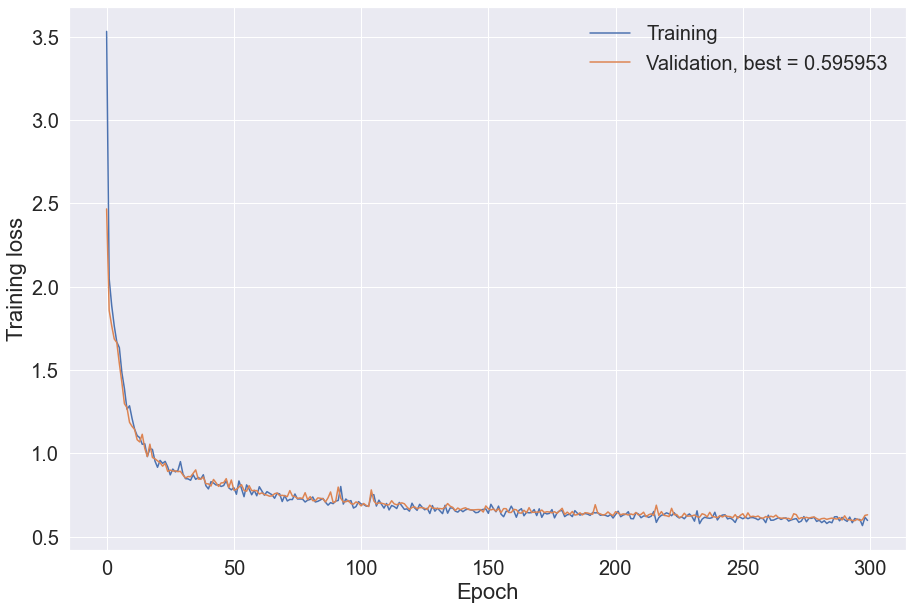

In [9]:
plt.gcf().set_size_inches(15, 10)

logs_trn = get_tensorboard_logs(path_to_events_file_train, 'epoch_loss')
logs_val = get_tensorboard_logs(path_to_events_file_val, 'epoch_loss')

m = min(logs_val)

plt.plot(logs_trn, label='Training')
plt.plot(logs_val, label=f'Validation, best = {round(float(m),6)}')
plt.legend(frameon=False)

plt.ylabel("Training loss")
plt.xlabel("Epoch")
plt.savefig(os.path.join(module_path, "reports", "figures", "Stardist", "trained_on_raw", "training_logs", "exp01-logs-loss.png"), bbox_inches='tight')

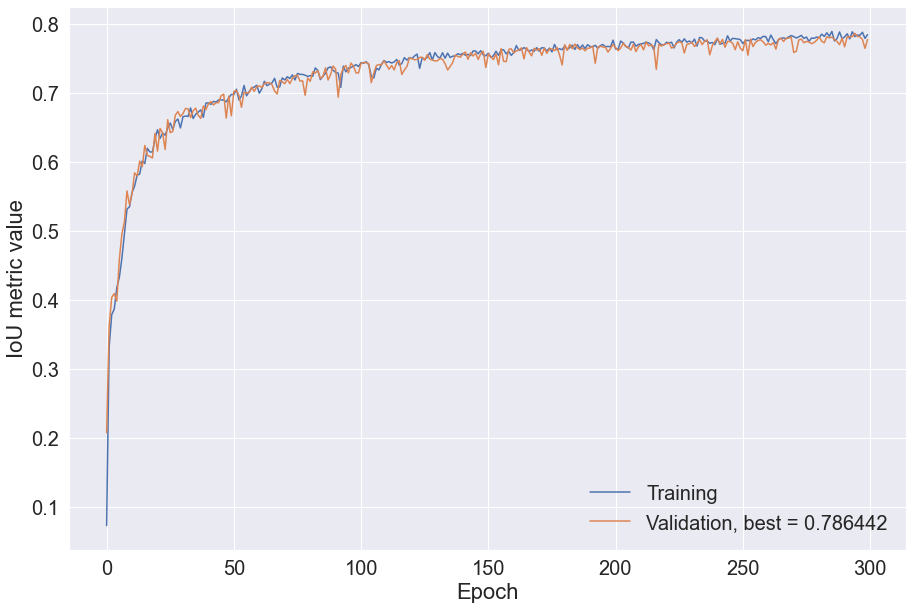

In [10]:
plt.gcf().set_size_inches(15, 10)

logs_trn = get_tensorboard_logs(path_to_events_file_train, 'epoch_dist_dist_iou_metric')
logs_val = get_tensorboard_logs(path_to_events_file_val, 'epoch_dist_dist_iou_metric')

m = max(logs_val)

plt.plot(logs_trn, label='Training')
plt.plot(logs_val, label=f'Validation, best = {round(float(m),6)}')
plt.legend(frameon=False)

plt.ylabel("IoU metric value")
plt.xlabel("Epoch")
plt.savefig(os.path.join(module_path, "reports", "figures", "Stardist", "trained_on_raw", "training_logs", "exp01-logs-eval.png"), bbox_inches='tight')